In [1]:
import pm4py
log = pm4py.read_xes("only_procfiler.xes")
log

d:\Programs\Programming\Python\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

,concept:name,time:timestamp,ManagedThreadId,NativeThreadId,QpcStamp,concept:instance,lifecycle:transition,case:concept:name
0,Procfiler/MethodStart_{Microsoft.CodeAnalysis....,2025-01-10 20:01:47.093946+00:00,25452,25452,13371926562902,NaN,NaN,1
1,Procfiler/MethodStart_{Interop+Advapi32.EventA...,2025-01-10 20:01:47.094207+00:00,25452,25452,13371926565514,NaN,NaN,1
2,Procfiler/MethodEnd_{Interop+Advapi32.EventAct...,2025-01-10 20:01:47.094208+00:00,25452,25452,13371926565518,NaN,NaN,1
3,Procfiler/MethodStart_{Interop+Advapi32.EventA...,2025-01-10 20:01:47.094226+00:00,25452,25452,13371926565700,NaN,NaN,1
4,Procfiler/MethodEnd_{Interop+Advapi32.EventAct...,2025-01-10 20:01:47.094226+00:00,25452,25452,13371926565701,NaN,NaN,1
...,...,...,...,...,...,...,...,...
1894287,Procfiler/MethodEnd_{Microsoft.CodeAnalysis.Co...,2025-01-10 20:03:37.599533+00:00,18968,18968,13373031605845,NaN,NaN,12
1894288,Procfiler/MethodStart_{Microsoft.CodeAnalysis....,2025-01-10 20:03:37.599576+00:00,18968,18968,13373031606272,NaN,NaN,12
1894289,Procfiler/MethodEnd_{Microsoft.CodeAnalysis.Co...,2025-01-10 20:03:37.599580+00:00,18968,18968,13373031606318,NaN,NaN,12
1894290,Procfiler/MethodEnd_{Microsoft.CodeAnalysis.CS...,2025-01-10 20:03:37.599580+00:00,18968,18968,13373031606321,NaN,NaN,12


In [5]:
heuristics_net = pm4py.discover_heuristics_net(
    log.copy(),
    min_dfg_occurrences = 10000
)

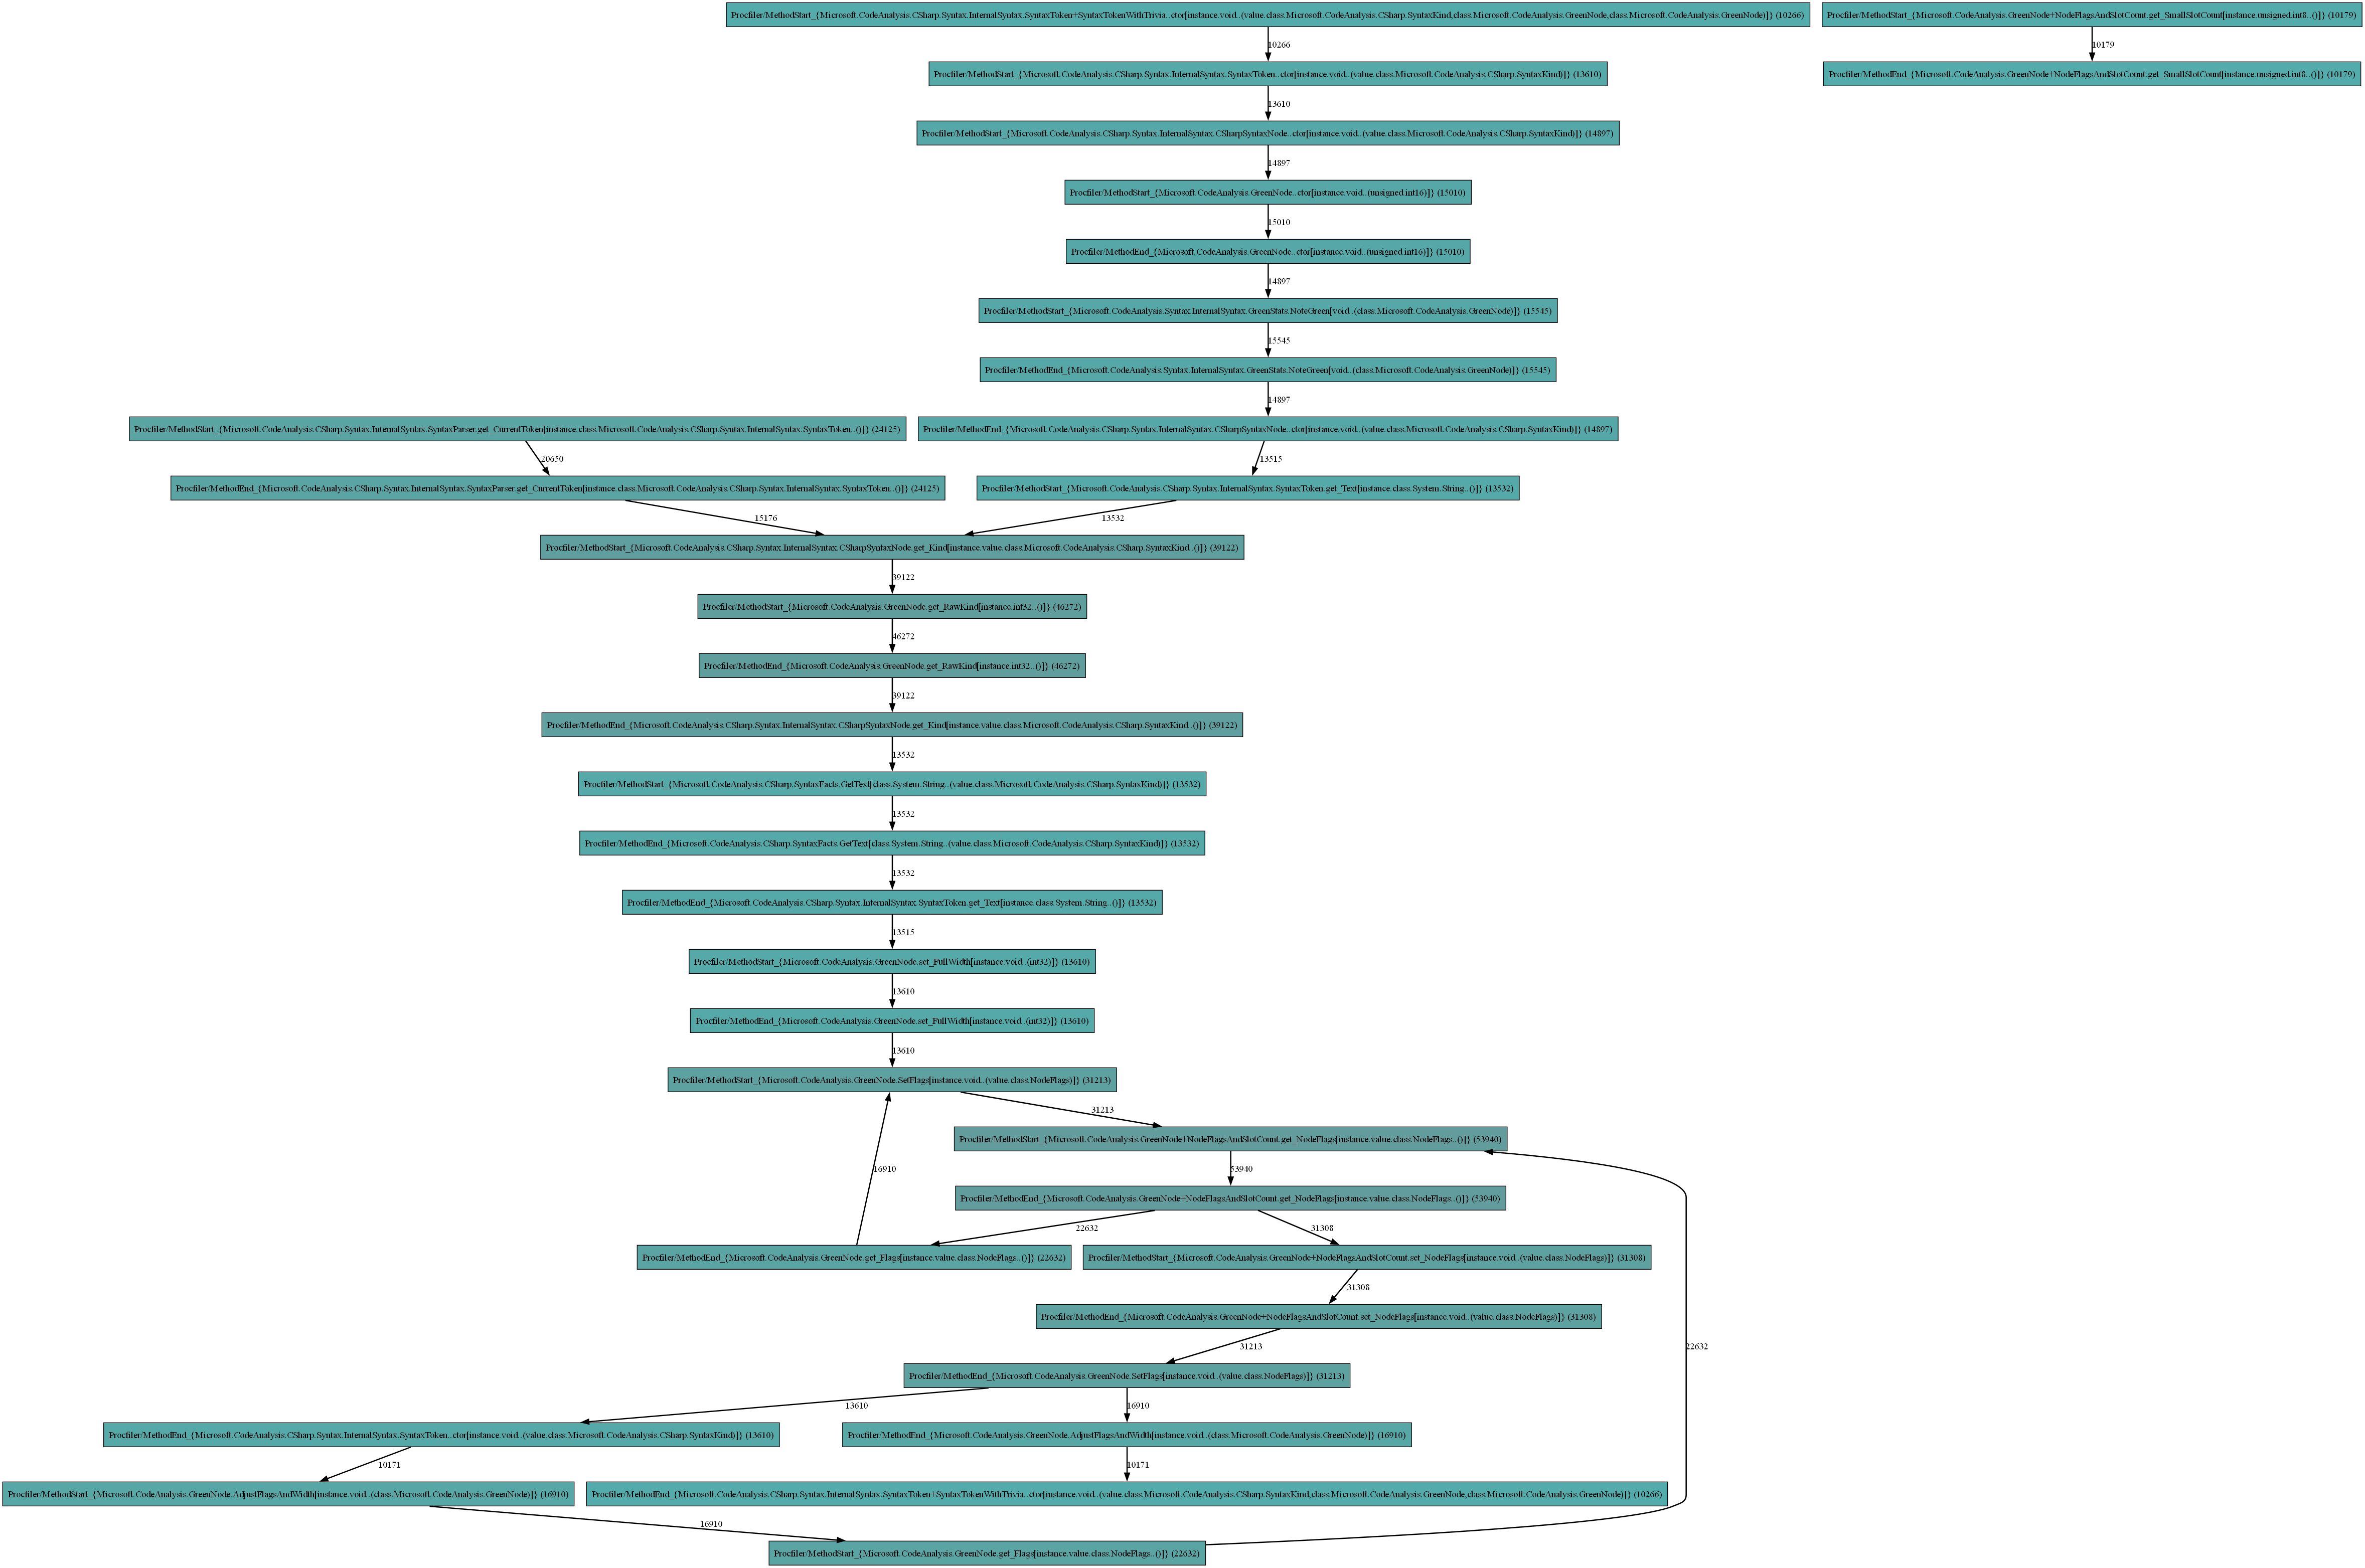

In [6]:
pm4py.view_heuristics_net(heuristics_net)

In [ ]:
import re
import tqdm

def process_event_name(text: str) -> str:
    # Remove Procfiler/Method
    if text.startswith("Procfiler/MethodStart_{"):
        text = "Start:" + text[len("Procfiler/MethodStart_{"):-1]
    elif text.startswith("Procfiler/MethodEnd_{"):
        text = "End:" + text[len("Procfiler/MethodEnd_{"):-1]
    else:
        print(f"Bad format: {text}")
        raise ValueError

    # Remove garbage packages
    if text.startswith("Start:Roslyn.Utilities") or text.startswith("End:Roslyn.Utilities"):
        return None
    if text.startswith("Start:<PrivateImplementationDetails>") or text.startswith("End:<PrivateImplementationDetails>"):
        return None
    if text.startswith("Start:Interop") or text.startswith("End:Interop"):
        return None
    if text.startswith("Start:Microsoft.Win32") or text.startswith("End:Microsoft.Win32"):
        return None
    
    # Only Microsoft.CodeAnalysis remains. Remove it.
    if text.startswith("Start:Microsoft.CodeAnalysis."):
        text = "Start:" + text[len("Start:Microsoft.CodeAnalysis."):]
    elif text.startswith("End:Microsoft.CodeAnalysis."):
        text = "End:" + text[len("End:Microsoft.CodeAnalysis."):]
    else:
        print(f"Bad format: {text}")
        raise ValueError

    # Remove square brackets
    text = re.sub(r'\[(.*)\]', '', text)

    # Ensure everything is expected
    assert re.match(r'^(Start|End)\:[a-zA-Z0-9\.\+\_\`<>|]*$', text)

    return text

log["concept:name"] = log["concept:name"].apply(process_event_name)

In [59]:
log = log[~log["concept:name"].isna()]
log["concept:name"].value_counts()

concept:name
End:GreenNode+NodeFlagsAndSlotCount.get_NodeFlags                      53940
Start:GreenNode+NodeFlagsAndSlotCount.get_NodeFlags                    53940
Start:GreenNode.get_RawKind                                            46272
End:GreenNode.get_RawKind                                              46272
End:CSharp.Syntax.InternalSyntax.CSharpSyntaxNode.get_Kind             39122
                                                                       ...  
End:CSharp.Syntax.InternalSyntax.LanguageParser.ParseThrowStatement        1
Start:CSharp.Syntax.BaseListSyntax..ctor                                   1
Start:CSharp.Syntax.InternalSyntax.ContextAwareSyntax.FinallyClause        1
Start:CSharp.Syntax.InternalSyntax.FinallyClauseSyntax..ctor               1
End:CSharp.WithTypeParametersBinder.get_LookupMask                         1
Name: count, Length: 6214, dtype: int64

In [60]:
log.shape

(1785986, 8)

In [61]:
pm4py.write_xes(log, "after_regex.xes")

exporting log, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

In [62]:
from utils.merge_paired_events import merge_paired_events

merged_log = merge_paired_events(log)
merged_log

100%|█████████▉| 1274165/1274167 [06:57<00:00, 3052.17it/s] 


,concept:name,time:timestamp,ManagedThreadId,NativeThreadId,QpcStamp,concept:instance,lifecycle:transition,case:concept:name
0,Start:CSharp.CommandLine.Program.Main\nStart:C...,2025-01-10 20:01:47.093946+00:00,25452,25452,13371926562902,NaN,NaN,1
1,Start:RuntimeHostInfo.get_IsCoreClrRuntime\nEn...,2025-01-10 20:01:47.215063+00:00,25452,25452,13371927774072,NaN,NaN,1
2,End:CommandLine.BuildClient.GetSystemSdkDirectory,2025-01-10 20:01:47.215069+00:00,25452,25452,13371927774131,NaN,NaN,1
3,Start:RuntimeHostInfo.get_IsCoreClrRuntime\nEn...,2025-01-10 20:01:47.215069+00:00,25452,25452,13371927774134,NaN,NaN,1
4,Start:CommandLine.BuildClient..ctor\nEnd:Comma...,2025-01-10 20:01:47.216577+00:00,25452,25452,13371927789208,NaN,NaN,1
...,...,...,...,...,...,...,...,...
1274162,Start:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599444+00:00,18968,18968,13373031604955,NaN,NaN,12
1274163,End:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599444+00:00,18968,18968,13373031604960,NaN,NaN,12
1274164,End:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599445+00:00,18968,18968,13373031604962,NaN,NaN,12
1274165,End:DiagnosticBag.Free,2025-01-10 20:03:37.599445+00:00,18968,18968,13373031604964,NaN,NaN,12


In [64]:
merged_log['concept:name'].value_counts()

concept:name
Start:GreenNode+NodeFlagsAndSlotCount.get_NodeFlags\nEnd:GreenNode+NodeFlagsAndSlotCount.get_NodeFlags                                                                                         53940
Start:GreenNode.get_RawKind\nEnd:GreenNode.get_RawKind                                                                                                                                         46272
Start:CSharp.Syntax.InternalSyntax.CSharpSyntaxNode.get_Kind                                                                                                                                   39122
End:CSharp.Syntax.InternalSyntax.CSharpSyntaxNode.get_Kind                                                                                                                                     39122
Start:GreenNode+NodeFlagsAndSlotCount.set_NodeFlags\nEnd:GreenNode+NodeFlagsAndSlotCount.set_NodeFlags                                                                                         31308
  

In [9]:
import pm4py
merged_log = pm4py.read_xes("merged_events.xes")

parsing log, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
merged_log = merged_log.drop(columns = [ "concept:instance", "lifecycle:transition", "ManagedThreadId", "NativeThreadId", "QpcStamp" ])
merged_log

,concept:name,time:timestamp,case:concept:name
0,Start:CSharp.CommandLine.Program.Main\nStart:C...,2025-01-10 20:01:47.093946+00:00,1
1,Start:RuntimeHostInfo.get_IsCoreClrRuntime\nEn...,2025-01-10 20:01:47.215063+00:00,1
2,End:CommandLine.BuildClient.GetSystemSdkDirectory,2025-01-10 20:01:47.215069+00:00,1
3,Start:RuntimeHostInfo.get_IsCoreClrRuntime\nEn...,2025-01-10 20:01:47.215069+00:00,1
4,Start:CommandLine.BuildClient..ctor\nEnd:Comma...,2025-01-10 20:01:47.216577+00:00,1
...,...,...,...
1274162,Start:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599444+00:00,12
1274163,End:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599444+00:00,12
1274164,End:PooledObjects.ObjectPool`1,2025-01-10 20:03:37.599445+00:00,12
1274165,End:DiagnosticBag.Free,2025-01-10 20:03:37.599445+00:00,12


In [11]:
pm4py.write_xes(merged_log, "merged_events.xes")

exporting log, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]